In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pathlib
from metrics import is_fid_pytorch

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
torch.__version__

'1.10.0'

In [2]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

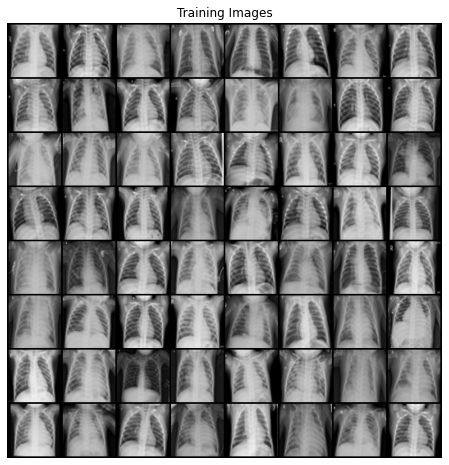

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize([image_size,image_size]),
#                                transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.500, 0.500, 0.500), (0.500, 0.500, 0.500)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 16),
#             nn.ReLU(True),
            
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
is_fid_model = is_fid_pytorch.ScoreModel(mode=2, stats_file='data/xray.npz')

In [31]:
# Training Loop

# Lists to keep track of progress
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0
# fid_list = []
# is_mu = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    is_mean, is_std, fid = is_fid_model.get_score_image_tensor(fake)
    is_mu.append(is_mean)
    fid_list.append(fid)
    if fid<280:
        torch.save(netG.state_dict(),'fid'+str(fid)+'.pt')
    print("is:",is_mean,"fid:",fid) 

Starting Training Loop...
[0/100][0/92]	Loss_D: 0.2389	Loss_G: 7.2830	D(x): 0.9687	D(G(z)): 0.1448 / 0.0033
[0/100][50/92]	Loss_D: 0.1414	Loss_G: 4.4215	D(x): 0.9174	D(G(z)): 0.0158 / 0.0249


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.505723843039639 fid: 256.95324256414216
[1/100][0/92]	Loss_D: 0.1922	Loss_G: 4.2175	D(x): 0.8732	D(G(z)): 0.0080 / 0.0336
[1/100][50/92]	Loss_D: 0.2096	Loss_G: 5.0530	D(x): 0.8662	D(G(z)): 0.0045 / 0.0173


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.45it/s]


is: 1.745551676524101 fid: 286.13302780289223
[2/100][0/92]	Loss_D: 0.3886	Loss_G: 16.1905	D(x): 0.9976	D(G(z)): 0.2224 / 0.0000
[2/100][50/92]	Loss_D: 0.0897	Loss_G: 5.4437	D(x): 0.9646	D(G(z)): 0.0417 / 0.0084


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.45it/s]


is: 1.6517525343965844 fid: 268.55382668825854
[3/100][0/92]	Loss_D: 0.1356	Loss_G: 5.6262	D(x): 0.9606	D(G(z)): 0.0746 / 0.0074
[3/100][50/92]	Loss_D: 0.1094	Loss_G: 6.1876	D(x): 0.9691	D(G(z)): 0.0663 / 0.0039


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.19it/s]


is: 1.626571157819614 fid: 281.5597183391583
[4/100][0/92]	Loss_D: 0.1096	Loss_G: 5.8734	D(x): 0.9267	D(G(z)): 0.0192 / 0.0083
[4/100][50/92]	Loss_D: 0.0985	Loss_G: 6.5642	D(x): 0.9962	D(G(z)): 0.0841 / 0.0042


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.48it/s]


is: 1.8358244979317369 fid: 255.57840559956227
[5/100][0/92]	Loss_D: 0.0944	Loss_G: 4.5283	D(x): 0.9558	D(G(z)): 0.0379 / 0.0195
[5/100][50/92]	Loss_D: 0.0549	Loss_G: 7.9734	D(x): 0.9661	D(G(z)): 0.0138 / 0.0022


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.52it/s]


is: 1.7291511012827523 fid: 283.2335392280727
[6/100][0/92]	Loss_D: 0.1079	Loss_G: 7.2244	D(x): 0.9696	D(G(z)): 0.0656 / 0.0016
[6/100][50/92]	Loss_D: 0.0579	Loss_G: 5.9280	D(x): 0.9640	D(G(z)): 0.0152 / 0.0061


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.50it/s]


is: 1.6592813493184404 fid: 260.3712933336635
[7/100][0/92]	Loss_D: 0.1678	Loss_G: 6.4017	D(x): 0.9773	D(G(z)): 0.1182 / 0.0036
[7/100][50/92]	Loss_D: 0.0548	Loss_G: 6.2788	D(x): 0.9663	D(G(z)): 0.0141 / 0.0072


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.5638417750471174 fid: 280.0390275429236
[8/100][0/92]	Loss_D: 0.2379	Loss_G: 5.9289	D(x): 0.9044	D(G(z)): 0.0633 / 0.0137
[8/100][50/92]	Loss_D: 0.0627	Loss_G: 6.1503	D(x): 0.9782	D(G(z)): 0.0336 / 0.0055


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.42it/s]


is: 1.6513139100642227 fid: 255.49989274804537
[9/100][0/92]	Loss_D: 0.0566	Loss_G: 5.3924	D(x): 0.9834	D(G(z)): 0.0351 / 0.0093
[9/100][50/92]	Loss_D: 0.0958	Loss_G: 4.3154	D(x): 0.9572	D(G(z)): 0.0446 / 0.0205


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]


is: 1.659888603686198 fid: 268.3659760028878
[10/100][0/92]	Loss_D: 0.2800	Loss_G: 12.1836	D(x): 0.9872	D(G(z)): 0.1916 / 0.0001
[10/100][50/92]	Loss_D: 0.0922	Loss_G: 5.9911	D(x): 0.9804	D(G(z)): 0.0642 / 0.0056


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.747899837249566 fid: 259.65549197967994
[11/100][0/92]	Loss_D: 0.3101	Loss_G: 5.1006	D(x): 0.8075	D(G(z)): 0.0016 / 0.0143
[11/100][50/92]	Loss_D: 0.0554	Loss_G: 6.1045	D(x): 0.9739	D(G(z)): 0.0251 / 0.0060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5770911009184718 fid: 275.04627797980015
[12/100][0/92]	Loss_D: 0.0306	Loss_G: 6.6243	D(x): 0.9801	D(G(z)): 0.0086 / 0.0139
[12/100][50/92]	Loss_D: 0.0888	Loss_G: 8.4230	D(x): 0.9392	D(G(z)): 0.0013 / 0.0047


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.6963785157388216 fid: 262.3752086239118
[13/100][0/92]	Loss_D: 0.0523	Loss_G: 6.0415	D(x): 0.9868	D(G(z)): 0.0364 / 0.0047
[13/100][50/92]	Loss_D: 0.2330	Loss_G: 10.9437	D(x): 0.8421	D(G(z)): 0.0004 / 0.0021


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.5970282147512842 fid: 259.93795604787636
[14/100][0/92]	Loss_D: 0.0758	Loss_G: 4.7134	D(x): 0.9620	D(G(z)): 0.0305 / 0.0161
[14/100][50/92]	Loss_D: 0.0711	Loss_G: 6.9797	D(x): 0.9839	D(G(z)): 0.0489 / 0.0025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5750462928119018 fid: 275.07625540866536
[15/100][0/92]	Loss_D: 0.0384	Loss_G: 5.9243	D(x): 0.9823	D(G(z)): 0.0170 / 0.0060
[15/100][50/92]	Loss_D: 0.0874	Loss_G: 7.1098	D(x): 0.9870	D(G(z)): 0.0666 / 0.0028


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.5544038262838584 fid: 288.85855770287594
[16/100][0/92]	Loss_D: 1.2803	Loss_G: 9.7878	D(x): 0.5703	D(G(z)): 0.0056 / 0.1589
[16/100][50/92]	Loss_D: 0.0674	Loss_G: 5.8573	D(x): 0.9760	D(G(z)): 0.0394 / 0.0058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.7733804961419017 fid: 264.7772537142952
[17/100][0/92]	Loss_D: 0.1213	Loss_G: 5.4536	D(x): 0.9390	D(G(z)): 0.0457 / 0.0101
[17/100][50/92]	Loss_D: 0.0554	Loss_G: 6.2582	D(x): 0.9633	D(G(z)): 0.0111 / 0.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.5058678435391557 fid: 247.15693366745725
[18/100][0/92]	Loss_D: 0.2495	Loss_G: 3.8963	D(x): 0.8274	D(G(z)): 0.0031 / 0.0582
[18/100][50/92]	Loss_D: 0.0688	Loss_G: 5.3781	D(x): 0.9780	D(G(z)): 0.0418 / 0.0080


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 1.6147947057705203 fid: 247.25372538276258
[19/100][0/92]	Loss_D: 0.0633	Loss_G: 5.9278	D(x): 0.9879	D(G(z)): 0.0461 / 0.0055
[19/100][50/92]	Loss_D: 0.1159	Loss_G: 4.5405	D(x): 0.9264	D(G(z)): 0.0237 / 0.0213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.98it/s]


is: 1.959192322680175 fid: 255.2717526459669
[20/100][0/92]	Loss_D: 0.0716	Loss_G: 5.6805	D(x): 0.9562	D(G(z)): 0.0103 / 0.0084
[20/100][50/92]	Loss_D: 0.0836	Loss_G: 4.8311	D(x): 0.9558	D(G(z)): 0.0298 / 0.0164


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.74it/s]


is: 1.6481006095817974 fid: 277.15696237896
[21/100][0/92]	Loss_D: 0.5544	Loss_G: 2.2774	D(x): 0.7023	D(G(z)): 0.0006 / 0.2029
[21/100][50/92]	Loss_D: 0.0419	Loss_G: 9.2194	D(x): 0.9663	D(G(z)): 0.0020 / 0.0005


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.6505228187632734 fid: 271.2784302284076
[22/100][0/92]	Loss_D: 0.1180	Loss_G: 6.7687	D(x): 0.9952	D(G(z)): 0.0980 / 0.0020
[22/100][50/92]	Loss_D: 0.0693	Loss_G: 5.1797	D(x): 0.9526	D(G(z)): 0.0150 / 0.0170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.41it/s]


is: 1.8139293308568185 fid: 257.20533416321734
[23/100][0/92]	Loss_D: 0.0397	Loss_G: 5.7183	D(x): 0.9897	D(G(z)): 0.0274 / 0.0069
[23/100][50/92]	Loss_D: 0.3590	Loss_G: 8.0731	D(x): 0.9092	D(G(z)): 0.1063 / 0.0510


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.7672882104594723 fid: 290.76088322678436
[24/100][0/92]	Loss_D: 0.3652	Loss_G: 12.0828	D(x): 0.9936	D(G(z)): 0.2481 / 0.0001
[24/100][50/92]	Loss_D: 0.0511	Loss_G: 5.8115	D(x): 0.9772	D(G(z)): 0.0246 / 0.0069


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.20it/s]


is: 1.5552136762885085 fid: 275.8353325499128
[25/100][0/92]	Loss_D: 0.0306	Loss_G: 6.4288	D(x): 0.9910	D(G(z)): 0.0203 / 0.0035
[25/100][50/92]	Loss_D: 0.0931	Loss_G: 5.5834	D(x): 0.9747	D(G(z)): 0.0601 / 0.0067


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.8771513769568067 fid: 274.24123068680876
[26/100][0/92]	Loss_D: 0.9827	Loss_G: 20.2200	D(x): 0.9986	D(G(z)): 0.5645 / 0.0000
[26/100][50/92]	Loss_D: 0.0946	Loss_G: 5.3042	D(x): 0.9660	D(G(z)): 0.0510 / 0.0089


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.15it/s]


is: 1.5773561770219546 fid: 262.56947340978206
[27/100][0/92]	Loss_D: 0.0879	Loss_G: 3.7203	D(x): 0.9511	D(G(z)): 0.0197 / 0.0349
[27/100][50/92]	Loss_D: 0.0450	Loss_G: 6.2048	D(x): 0.9836	D(G(z)): 0.0267 / 0.0041


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.6754503068578206 fid: 267.1123288530456
[28/100][0/92]	Loss_D: 0.0418	Loss_G: 7.5944	D(x): 0.9687	D(G(z)): 0.0075 / 0.0054
[28/100][50/92]	Loss_D: 0.0945	Loss_G: 4.5792	D(x): 0.9561	D(G(z)): 0.0394 / 0.0198


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.10it/s]


is: 1.651499818709663 fid: 243.80795070579893
[29/100][0/92]	Loss_D: 0.1284	Loss_G: 6.8386	D(x): 0.9789	D(G(z)): 0.0889 / 0.0019
[29/100][50/92]	Loss_D: 0.1094	Loss_G: 3.8583	D(x): 0.9501	D(G(z)): 0.0458 / 0.0331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.764122343103486 fid: 248.09137155847503
[30/100][0/92]	Loss_D: 1.7033	Loss_G: 2.1241	D(x): 0.3861	D(G(z)): 0.0001 / 0.4530
[30/100][50/92]	Loss_D: 0.0639	Loss_G: 5.9003	D(x): 0.9792	D(G(z)): 0.0388 / 0.0052


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.573263584093998 fid: 267.1330138797074
[31/100][0/92]	Loss_D: 0.0502	Loss_G: 5.1854	D(x): 0.9724	D(G(z)): 0.0194 / 0.0128
[31/100][50/92]	Loss_D: 0.1036	Loss_G: 5.4795	D(x): 0.9603	D(G(z)): 0.0542 / 0.0078


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.92it/s]


is: 1.6980307928381015 fid: 284.3332313823917
[32/100][0/92]	Loss_D: 0.1934	Loss_G: 7.8010	D(x): 0.9779	D(G(z)): 0.0987 / 0.0013
[32/100][50/92]	Loss_D: 0.0533	Loss_G: 7.6117	D(x): 0.9606	D(G(z)): 0.0031 / 0.0015


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.74it/s]


is: 1.7008043798480117 fid: 265.1046215610244
[33/100][0/92]	Loss_D: 0.0797	Loss_G: 5.0722	D(x): 0.9679	D(G(z)): 0.0429 / 0.0098
[33/100][50/92]	Loss_D: 0.0873	Loss_G: 5.0934	D(x): 0.9404	D(G(z)): 0.0172 / 0.0122


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.5798264570674492 fid: 249.76989500892387
[34/100][0/92]	Loss_D: 0.2040	Loss_G: 8.1793	D(x): 0.9986	D(G(z)): 0.1566 / 0.0006
[34/100][50/92]	Loss_D: 0.0459	Loss_G: 5.9133	D(x): 0.9772	D(G(z)): 0.0202 / 0.0055


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.69it/s]


is: 1.7075663190037431 fid: 259.66695881950426
[35/100][0/92]	Loss_D: 0.1083	Loss_G: 6.8688	D(x): 0.9869	D(G(z)): 0.0817 / 0.0016
[35/100][50/92]	Loss_D: 0.0331	Loss_G: 7.0980	D(x): 0.9851	D(G(z)): 0.0167 / 0.0116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.6350861535610473 fid: 273.7491934400822
[36/100][0/92]	Loss_D: 0.0428	Loss_G: 5.3251	D(x): 0.9755	D(G(z)): 0.0148 / 0.0126
[36/100][50/92]	Loss_D: 0.5144	Loss_G: 8.2362	D(x): 0.7382	D(G(z)): 0.0084 / 0.2757


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5241506602813213 fid: 262.4295220985323
[37/100][0/92]	Loss_D: 0.0969	Loss_G: 5.0727	D(x): 0.9535	D(G(z)): 0.0380 / 0.0118
[37/100][50/92]	Loss_D: 0.0640	Loss_G: 5.9414	D(x): 0.9769	D(G(z)): 0.0346 / 0.0065


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


is: 1.6784610015792558 fid: 248.30881000903648
[38/100][0/92]	Loss_D: 0.1030	Loss_G: 5.7382	D(x): 0.9551	D(G(z)): 0.0413 / 0.0080
[38/100][50/92]	Loss_D: 0.0351	Loss_G: 5.9540	D(x): 0.9742	D(G(z)): 0.0068 / 0.0050


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.64it/s]


is: 1.590416480125724 fid: 252.9553099574737
[39/100][0/92]	Loss_D: 0.3872	Loss_G: 8.1796	D(x): 0.8220	D(G(z)): 0.0081 / 0.1184
[39/100][50/92]	Loss_D: 0.0509	Loss_G: 5.0230	D(x): 0.9790	D(G(z)): 0.0208 / 0.0112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.42it/s]


is: 1.6057901188572998 fid: 268.57224571479225
[40/100][0/92]	Loss_D: 0.0544	Loss_G: 5.6475	D(x): 0.9869	D(G(z)): 0.0365 / 0.0067
[40/100][50/92]	Loss_D: 0.0542	Loss_G: 5.6380	D(x): 0.9866	D(G(z)): 0.0382 / 0.0067


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.56it/s]


is: 1.6821876270808267 fid: 258.1780057614062
[41/100][0/92]	Loss_D: 0.0450	Loss_G: 5.8039	D(x): 0.9860	D(G(z)): 0.0281 / 0.0058
[41/100][50/92]	Loss_D: 0.0572	Loss_G: 5.5910	D(x): 0.9767	D(G(z)): 0.0296 / 0.0064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.13it/s]


is: 1.4778563023100897 fid: 299.76279122970647
[42/100][0/92]	Loss_D: 0.0630	Loss_G: 11.4625	D(x): 0.9504	D(G(z)): 0.0034 / 0.0056
[42/100][50/92]	Loss_D: 0.1686	Loss_G: 10.9384	D(x): 0.9414	D(G(z)): 0.0316 / 0.0073


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 1.7603916710687249 fid: 282.146590908122
[43/100][0/92]	Loss_D: 0.0738	Loss_G: 8.2840	D(x): 0.9611	D(G(z)): 0.0261 / 0.0094
[43/100][50/92]	Loss_D: 0.0453	Loss_G: 7.1905	D(x): 0.9758	D(G(z)): 0.0146 / 0.0044


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.5230734694918966 fid: 275.8902162447391
[44/100][0/92]	Loss_D: 0.0237	Loss_G: 8.6578	D(x): 0.9814	D(G(z)): 0.0035 / 0.0010
[44/100][50/92]	Loss_D: 0.1266	Loss_G: 4.5038	D(x): 0.9410	D(G(z)): 0.0253 / 0.0209


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.53it/s]


is: 1.5101147055681898 fid: 249.05033516580528
[45/100][0/92]	Loss_D: 0.0273	Loss_G: 7.0402	D(x): 0.9943	D(G(z)): 0.0206 / 0.0025
[45/100][50/92]	Loss_D: 0.0836	Loss_G: 5.6741	D(x): 0.9450	D(G(z)): 0.0052 / 0.0071


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.18it/s]


is: 1.7684166902835075 fid: 299.3382418891033
[46/100][0/92]	Loss_D: 0.6220	Loss_G: 18.7053	D(x): 0.9953	D(G(z)): 0.3914 / 0.0000
[46/100][50/92]	Loss_D: 0.0497	Loss_G: 6.6593	D(x): 0.9657	D(G(z)): 0.0092 / 0.0061


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.63it/s]


is: 1.664174994557177 fid: 256.40192566784333
[47/100][0/92]	Loss_D: 0.0622	Loss_G: 6.0370	D(x): 0.9767	D(G(z)): 0.0350 / 0.0046
[47/100][50/92]	Loss_D: 0.1176	Loss_G: 4.8655	D(x): 0.9240	D(G(z)): 0.0213 / 0.0154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.48it/s]


is: 1.8370717682333126 fid: 271.92340067930564
[48/100][0/92]	Loss_D: 0.0762	Loss_G: 5.7617	D(x): 0.9918	D(G(z)): 0.0567 / 0.0074
[48/100][50/92]	Loss_D: 0.0891	Loss_G: 5.4573	D(x): 0.9636	D(G(z)): 0.0292 / 0.0079


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.5293055859443478 fid: 261.5851320940178
[49/100][0/92]	Loss_D: 0.0822	Loss_G: 4.8900	D(x): 0.9422	D(G(z)): 0.0079 / 0.0153
[49/100][50/92]	Loss_D: 0.2075	Loss_G: 4.9319	D(x): 0.8734	D(G(z)): 0.0037 / 0.0462


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 1.5650087230873422 fid: 263.51418703656975
[50/100][0/92]	Loss_D: 0.0738	Loss_G: 5.6050	D(x): 0.9458	D(G(z)): 0.0055 / 0.0083
[50/100][50/92]	Loss_D: 0.1047	Loss_G: 5.1860	D(x): 0.9517	D(G(z)): 0.0422 / 0.0119


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.6162955498520197 fid: 285.13641757839457
[51/100][0/92]	Loss_D: 0.1655	Loss_G: 9.0361	D(x): 0.9843	D(G(z)): 0.1185 / 0.0007
[51/100][50/92]	Loss_D: 0.0336	Loss_G: 6.3081	D(x): 0.9764	D(G(z)): 0.0073 / 0.0040


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.61it/s]


is: 1.9508178965821634 fid: 285.74785532378684
[52/100][0/92]	Loss_D: 0.0877	Loss_G: 7.5036	D(x): 0.9934	D(G(z)): 0.0728 / 0.0017
[52/100][50/92]	Loss_D: 0.0451	Loss_G: 6.0742	D(x): 0.9889	D(G(z)): 0.0321 / 0.0036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.608984173801425 fid: 261.87937877227716
[53/100][0/92]	Loss_D: 0.1106	Loss_G: 7.6411	D(x): 0.9782	D(G(z)): 0.0753 / 0.0012
[53/100][50/92]	Loss_D: 0.0786	Loss_G: 6.4465	D(x): 0.9803	D(G(z)): 0.0504 / 0.0038


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.6239659297033289 fid: 268.56434679680626
[54/100][0/92]	Loss_D: 0.0773	Loss_G: 7.2854	D(x): 0.9957	D(G(z)): 0.0662 / 0.0018
[54/100][50/92]	Loss_D: 0.0732	Loss_G: 8.0832	D(x): 0.9427	D(G(z)): 0.0017 / 0.0019


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 1.5228267542032978 fid: 261.8296435853998
[55/100][0/92]	Loss_D: 0.1254	Loss_G: 8.5300	D(x): 0.9956	D(G(z)): 0.1023 / 0.0003
[55/100][50/92]	Loss_D: 0.0471	Loss_G: 5.9022	D(x): 0.9779	D(G(z)): 0.0201 / 0.0157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5381332213973369 fid: 285.7280034403235
[56/100][0/92]	Loss_D: 0.0755	Loss_G: 6.7309	D(x): 0.9691	D(G(z)): 0.0263 / 0.0038
[56/100][50/92]	Loss_D: 0.0340	Loss_G: 11.7914	D(x): 0.9846	D(G(z)): 0.0113 / 0.0007


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.02it/s]


is: 1.6170352058906665 fid: 281.9307517017702
[57/100][0/92]	Loss_D: 0.0704	Loss_G: 5.8401	D(x): 0.9781	D(G(z)): 0.0421 / 0.0051
[57/100][50/92]	Loss_D: 0.1071	Loss_G: 8.0371	D(x): 0.9980	D(G(z)): 0.0840 / 0.0008


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.45it/s]


is: 1.6684588657745851 fid: 271.228043712013
[58/100][0/92]	Loss_D: 0.0403	Loss_G: 6.6875	D(x): 0.9814	D(G(z)): 0.0196 / 0.0034
[58/100][50/92]	Loss_D: 0.0753	Loss_G: 6.3942	D(x): 0.9813	D(G(z)): 0.0484 / 0.0039


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.35it/s]


is: 1.6845373036455584 fid: 293.26174840241737
[59/100][0/92]	Loss_D: 0.1074	Loss_G: 4.9784	D(x): 0.9472	D(G(z)): 0.0377 / 0.0117
[59/100][50/92]	Loss_D: 0.0382	Loss_G: 5.6750	D(x): 0.9848	D(G(z)): 0.0210 / 0.0060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.7555430930965872 fid: 264.7891029745796
[60/100][0/92]	Loss_D: 0.0870	Loss_G: 7.0635	D(x): 0.9938	D(G(z)): 0.0717 / 0.0019
[60/100][50/92]	Loss_D: 0.0724	Loss_G: 6.1977	D(x): 0.9742	D(G(z)): 0.0389 / 0.0040


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.38it/s]


is: 1.6179107110606483 fid: 255.32624254461405
[61/100][0/92]	Loss_D: 0.1797	Loss_G: 12.0787	D(x): 0.9882	D(G(z)): 0.1079 / 0.0005
[61/100][50/92]	Loss_D: 0.0737	Loss_G: 6.7673	D(x): 0.9748	D(G(z)): 0.0425 / 0.0036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.80it/s]


is: 1.5793682991166889 fid: 254.25652058326557
[62/100][0/92]	Loss_D: 0.0452	Loss_G: 6.5790	D(x): 0.9743	D(G(z)): 0.0153 / 0.0064
[62/100][50/92]	Loss_D: 0.0405	Loss_G: 6.6174	D(x): 0.9963	D(G(z)): 0.0331 / 0.0029


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.92it/s]


is: 1.6256575240132125 fid: 252.63286193557587
[63/100][0/92]	Loss_D: 0.0810	Loss_G: 7.4868	D(x): 0.9887	D(G(z)): 0.0598 / 0.0019
[63/100][50/92]	Loss_D: 0.1159	Loss_G: 4.2554	D(x): 0.9378	D(G(z)): 0.0217 / 0.0279


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.95it/s]


is: 1.6465459120328412 fid: 278.1360664418299
[64/100][0/92]	Loss_D: 0.0828	Loss_G: 6.6622	D(x): 0.9420	D(G(z)): 0.0029 / 0.0042
[64/100][50/92]	Loss_D: 1.1498	Loss_G: 13.7150	D(x): 0.6398	D(G(z)): 0.0016 / 0.2777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.45it/s]


is: 1.4938125142038516 fid: 289.5515961688719
[65/100][0/92]	Loss_D: 0.0381	Loss_G: 13.1947	D(x): 0.9968	D(G(z)): 0.0327 / 0.0037
[65/100][50/92]	Loss_D: 0.0308	Loss_G: 6.3919	D(x): 0.9951	D(G(z)): 0.0248 / 0.0032


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.41it/s]


is: 1.5965768864738017 fid: 279.39139513837097
[66/100][0/92]	Loss_D: 0.0091	Loss_G: 9.2113	D(x): 0.9974	D(G(z)): 0.0060 / 0.0015
[66/100][50/92]	Loss_D: 0.2653	Loss_G: 4.8381	D(x): 0.8644	D(G(z)): 0.0038 / 0.0827


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.61it/s]


is: 1.6748818403956816 fid: 283.6693737563862
[67/100][0/92]	Loss_D: 0.0871	Loss_G: 4.7935	D(x): 0.9411	D(G(z)): 0.0118 / 0.0163
[67/100][50/92]	Loss_D: 0.1581	Loss_G: 10.8146	D(x): 0.9655	D(G(z)): 0.0660 / 0.0010


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 2.013338373214549 fid: 286.84591793783443
[68/100][0/92]	Loss_D: 0.0699	Loss_G: 5.2300	D(x): 0.9621	D(G(z)): 0.0106 / 0.0106
[68/100][50/92]	Loss_D: 0.2132	Loss_G: 10.9778	D(x): 0.9942	D(G(z)): 0.1530 / 0.0001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.20it/s]


is: 1.6227134277030975 fid: 260.5920643636367
[69/100][0/92]	Loss_D: 0.0581	Loss_G: 5.6612	D(x): 0.9798	D(G(z)): 0.0330 / 0.0055
[69/100][50/92]	Loss_D: 0.0725	Loss_G: 4.7529	D(x): 0.9519	D(G(z)): 0.0137 / 0.0178


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.26it/s]


is: 1.713398966842886 fid: 272.22493025866424
[70/100][0/92]	Loss_D: 0.0295	Loss_G: 5.8841	D(x): 0.9852	D(G(z)): 0.0132 / 0.0062
[70/100][50/92]	Loss_D: 0.0983	Loss_G: 7.8377	D(x): 0.9905	D(G(z)): 0.0785 / 0.0008


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


is: 1.5830612183206068 fid: 290.2055186198662
[71/100][0/92]	Loss_D: 0.0678	Loss_G: 6.4078	D(x): 0.9686	D(G(z)): 0.0076 / 0.0046
[71/100][50/92]	Loss_D: 0.0755	Loss_G: 4.3736	D(x): 0.9453	D(G(z)): 0.0053 / 0.0249


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.57it/s]


is: 1.6139368292131846 fid: 283.31980147545266
[72/100][0/92]	Loss_D: 0.0525	Loss_G: 6.1074	D(x): 0.9631	D(G(z)): 0.0090 / 0.0073
[72/100][50/92]	Loss_D: 0.0901	Loss_G: 5.0906	D(x): 0.9476	D(G(z)): 0.0195 / 0.0133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.70it/s]


is: 1.5099838439941355 fid: 270.0002853965458
[73/100][0/92]	Loss_D: 0.1233	Loss_G: 6.3896	D(x): 0.9157	D(G(z)): 0.0032 / 0.0062
[73/100][50/92]	Loss_D: 0.0288	Loss_G: 5.4838	D(x): 0.9810	D(G(z)): 0.0085 / 0.0072


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.72it/s]


is: 1.7292417435422465 fid: 275.34435422145845
[74/100][0/92]	Loss_D: 0.0527	Loss_G: 7.9480	D(x): 0.9639	D(G(z)): 0.0061 / 0.0048
[74/100][50/92]	Loss_D: 0.0440	Loss_G: 5.8134	D(x): 0.9870	D(G(z)): 0.0233 / 0.0058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.33it/s]


is: 1.6204262379062135 fid: 288.1134352863992
[75/100][0/92]	Loss_D: 0.0360	Loss_G: 8.9151	D(x): 0.9859	D(G(z)): 0.0190 / 0.0023
[75/100][50/92]	Loss_D: 0.0605	Loss_G: 5.8060	D(x): 0.9782	D(G(z)): 0.0322 / 0.0079


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.45it/s]


is: 1.8005609981355981 fid: 282.99376581487604
[76/100][0/92]	Loss_D: 0.1701	Loss_G: 11.5280	D(x): 0.9957	D(G(z)): 0.1415 / 0.0001
[76/100][50/92]	Loss_D: 0.8231	Loss_G: 0.9010	D(x): 0.6062	D(G(z)): 0.0002 / 0.5566


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 1.4971750929361332 fid: 295.1711371470012
[77/100][0/92]	Loss_D: 0.1518	Loss_G: 9.9863	D(x): 0.9984	D(G(z)): 0.1314 / 0.0002
[77/100][50/92]	Loss_D: 0.0512	Loss_G: 6.6818	D(x): 0.9768	D(G(z)): 0.0120 / 0.0030


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.41it/s]


is: 1.6088847816875262 fid: 268.8360956628761
[78/100][0/92]	Loss_D: 0.1257	Loss_G: 8.1694	D(x): 0.9910	D(G(z)): 0.0970 / 0.0011
[78/100][50/92]	Loss_D: 0.0329	Loss_G: 5.7509	D(x): 0.9788	D(G(z)): 0.0093 / 0.0070


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5641694934249226 fid: 258.9567310577351
[79/100][0/92]	Loss_D: 0.1492	Loss_G: 9.4859	D(x): 0.9943	D(G(z)): 0.1225 / 0.0006
[79/100][50/92]	Loss_D: 0.0308	Loss_G: 5.7992	D(x): 0.9960	D(G(z)): 0.0248 / 0.0057


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.582337213758213 fid: 277.5510504241158
[80/100][0/92]	Loss_D: 0.0425	Loss_G: 10.5929	D(x): 0.9731	D(G(z)): 0.0042 / 0.0015
[80/100][50/92]	Loss_D: 0.0354	Loss_G: 7.9649	D(x): 0.9787	D(G(z)): 0.0121 / 0.0027


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


is: 1.6193084411606034 fid: 283.5228864686535
[81/100][0/92]	Loss_D: 0.0826	Loss_G: 7.1523	D(x): 0.9854	D(G(z)): 0.0611 / 0.0019
[81/100][50/92]	Loss_D: 0.0655	Loss_G: 7.2594	D(x): 0.9795	D(G(z)): 0.0351 / 0.0014


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.74it/s]


is: 1.7077705766653353 fid: 285.75289226278466
[82/100][0/92]	Loss_D: 0.0976	Loss_G: 8.3077	D(x): 0.9900	D(G(z)): 0.0786 / 0.0007
[82/100][50/92]	Loss_D: 0.0395	Loss_G: 5.8238	D(x): 0.9785	D(G(z)): 0.0140 / 0.0057


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5386615512651176 fid: 265.2715905908086
[83/100][0/92]	Loss_D: 0.0617	Loss_G: 5.7173	D(x): 0.9668	D(G(z)): 0.0104 / 0.0096
[83/100][50/92]	Loss_D: 0.0209	Loss_G: 6.4949	D(x): 0.9938	D(G(z)): 0.0140 / 0.0037


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.831797001895945 fid: 260.6812269183271
[84/100][0/92]	Loss_D: 0.0300	Loss_G: 7.5625	D(x): 0.9882	D(G(z)): 0.0168 / 0.0017
[84/100][50/92]	Loss_D: 0.0337	Loss_G: 5.8904	D(x): 0.9857	D(G(z)): 0.0168 / 0.0052


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5460864372954826 fid: 260.6945827246354
[85/100][0/92]	Loss_D: 0.0302	Loss_G: 7.0902	D(x): 0.9779	D(G(z)): 0.0040 / 0.0033
[85/100][50/92]	Loss_D: 0.0733	Loss_G: 4.6575	D(x): 0.9498	D(G(z)): 0.0107 / 0.0234


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.5938143880554148 fid: 253.81999620880663
[86/100][0/92]	Loss_D: 0.0701	Loss_G: 7.1000	D(x): 0.9748	D(G(z)): 0.0335 / 0.0041
[86/100][50/92]	Loss_D: 0.2752	Loss_G: 11.7969	D(x): 0.9716	D(G(z)): 0.1400 / 0.0003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.6379129288783059 fid: 279.5998482736351
[87/100][0/92]	Loss_D: 0.0893	Loss_G: 8.2640	D(x): 0.9971	D(G(z)): 0.0758 / 0.0009
[87/100][50/92]	Loss_D: 0.0776	Loss_G: 7.9518	D(x): 0.9931	D(G(z)): 0.0626 / 0.0014


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.5111354116416646 fid: 265.3524775843988
[88/100][0/92]	Loss_D: 0.0821	Loss_G: 6.1794	D(x): 0.9812	D(G(z)): 0.0554 / 0.0037
[88/100][50/92]	Loss_D: 0.1115	Loss_G: 10.6309	D(x): 0.9316	D(G(z)): 0.0008 / 0.0010


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.62it/s]


is: 1.54983171480208 fid: 238.9041476621955
[89/100][0/92]	Loss_D: 0.0641	Loss_G: 5.4646	D(x): 0.9591	D(G(z)): 0.0184 / 0.0090
[89/100][50/92]	Loss_D: 0.0590	Loss_G: 4.4402	D(x): 0.9661	D(G(z)): 0.0188 / 0.0217


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.6878466691936853 fid: 259.2712172692999
[90/100][0/92]	Loss_D: 0.1289	Loss_G: 7.9753	D(x): 0.9992	D(G(z)): 0.1113 / 0.0008
[90/100][50/92]	Loss_D: 0.1330	Loss_G: 4.1301	D(x): 0.9335	D(G(z)): 0.0470 / 0.0257


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.75it/s]


is: 1.4108651009495812 fid: 245.07043153073056
[91/100][0/92]	Loss_D: 0.0153	Loss_G: 8.8317	D(x): 0.9951	D(G(z)): 0.0096 / 0.0012
[91/100][50/92]	Loss_D: 0.0686	Loss_G: 4.6214	D(x): 0.9627	D(G(z)): 0.0186 / 0.0199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.6115450253572292 fid: 308.4957951428052
[92/100][0/92]	Loss_D: 0.0868	Loss_G: 8.3020	D(x): 0.9925	D(G(z)): 0.0679 / 0.0016
[92/100][50/92]	Loss_D: 0.1917	Loss_G: 4.2667	D(x): 0.8723	D(G(z)): 0.0029 / 0.0362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.693326559551031 fid: 284.8218140019315
[93/100][0/92]	Loss_D: 0.0378	Loss_G: 6.0163	D(x): 0.9947	D(G(z)): 0.0301 / 0.0047
[93/100][50/92]	Loss_D: 0.0646	Loss_G: 5.3638	D(x): 0.9651	D(G(z)): 0.0168 / 0.0188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.62it/s]


is: 1.554612745594172 fid: 314.03496850383135
[94/100][0/92]	Loss_D: 0.1858	Loss_G: 9.8986	D(x): 0.9863	D(G(z)): 0.1357 / 0.0007
[94/100][50/92]	Loss_D: 0.0778	Loss_G: 4.6366	D(x): 0.9505	D(G(z)): 0.0139 / 0.0170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.83it/s]


is: 1.6028108022703755 fid: 265.0504275862363
[95/100][0/92]	Loss_D: 0.1374	Loss_G: 4.6200	D(x): 0.9075	D(G(z)): 0.0100 / 0.0215
[95/100][50/92]	Loss_D: 0.0431	Loss_G: 5.5722	D(x): 0.9829	D(G(z)): 0.0238 / 0.0068


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.7092907031073168 fid: 257.7611769644314
[96/100][0/92]	Loss_D: 0.0834	Loss_G: 6.7211	D(x): 0.9412	D(G(z)): 0.0031 / 0.0030
[96/100][50/92]	Loss_D: 0.0891	Loss_G: 7.9317	D(x): 0.9780	D(G(z)): 0.0543 / 0.0025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.51it/s]


is: 1.636913957987425 fid: 263.00731591125805
[97/100][0/92]	Loss_D: 0.1165	Loss_G: 9.4208	D(x): 0.9964	D(G(z)): 0.0961 / 0.0005
[97/100][50/92]	Loss_D: 0.1318	Loss_G: 6.3415	D(x): 0.9280	D(G(z)): 0.0023 / 0.0087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.28it/s]


is: 1.73519648861541 fid: 287.8665383698655
[98/100][0/92]	Loss_D: 0.0607	Loss_G: 6.2771	D(x): 0.9812	D(G(z)): 0.0385 / 0.0032
[98/100][50/92]	Loss_D: 0.0602	Loss_G: 6.8218	D(x): 0.9917	D(G(z)): 0.0476 / 0.0028


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.62it/s]


is: 1.4935866178782662 fid: 318.71576469961485
[99/100][0/92]	Loss_D: 0.1397	Loss_G: 13.7160	D(x): 0.9864	D(G(z)): 0.0703 / 0.0001
[99/100][50/92]	Loss_D: 0.0403	Loss_G: 6.4670	D(x): 0.9741	D(G(z)): 0.0097 / 0.0029


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.05it/s]


is: 1.7620134737740234 fid: 277.3386824362899


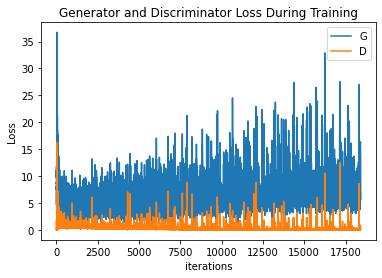

In [32]:
# plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

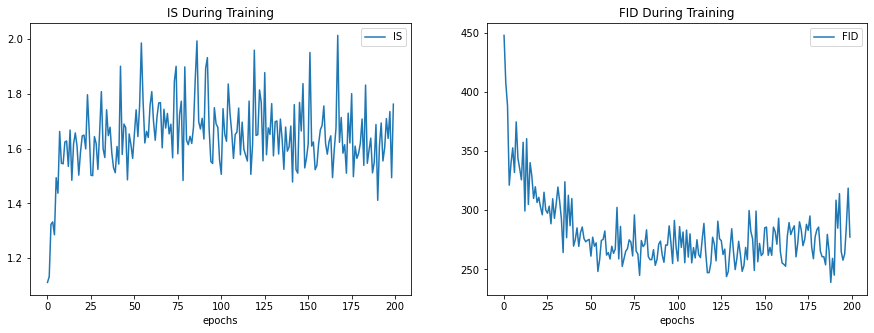

In [33]:
# plt.figure(figsize=(10,5))
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("IS During Training")
plt.plot(is_mu,label="IS")
plt.xlabel("epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(fid_list,label="FID")
plt.xlabel("epochs")
# plt.ylabel("Loss")
plt.legend()
plt.title("FID During Training")
plt.show()

In [22]:
from torchvision.utils import make_grid, save_image
try:
    os.mkdir('./gene_gan')
except:
    pass
fixed_noise1 = torch.randn(1000, nz, 1, 1, device=device)
fake = netG(fixed_noise1).detach().cpu()
for i in range(fake.shape[0]):
    save_image(fake[i], './gene_gan/'+str(i)+'.jpg')

In [40]:
best_model = Generator(ngpu).to(device)
best_model.load_state_dict(torch.load('fid238.pt', map_location=device))

<All keys matched successfully>

In [41]:
fake_best = best_model(fixed_noise1).detach().cpu()
try:
    os.mkdir('./gene_gan2')
except:
    pass
for i in range(fake_best.shape[0]):
    save_image(fake_best[i], './gene_gan2/'+str(i)+'.jpg')

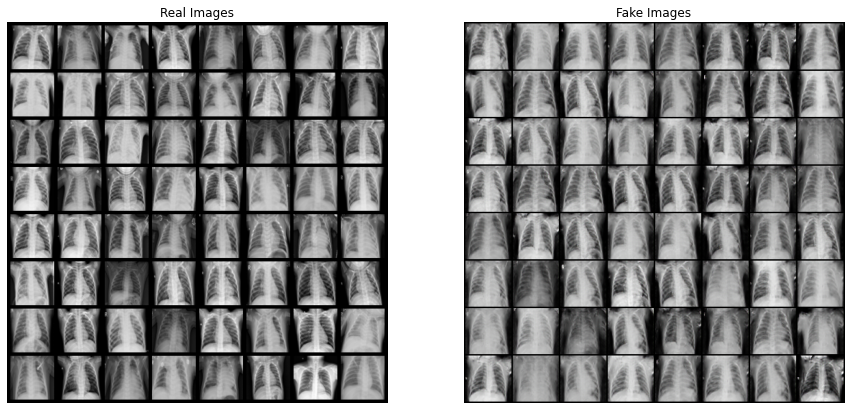

In [44]:
img_grid = vutils.make_grid(fake_best[:64], padding=2, normalize=True)

real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_grid,(1,2,0)))
plt.show()